In [1]:
import tensorflow as tf
import keras
import transformers
print("TensorFlow version:", tf.__version__)
print("Transformers version:", transformers.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.17.1
Transformers version: 4.47.0
Keras version: 3.5.0


In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import torch
from torch.utils.data import Dataset

In [3]:
# Load datasets
train_df = pd.read_csv('/kaggle/input/ma-tam/AWM_train.csv')
dev_df = pd.read_csv('/kaggle/input/ma-tam/AWM_dev.csv')
# test_without_label = pd.read_csv('/kaggle/input/ma-tam/AWM_test_without_labels.csv')
test_with_label = pd.read_csv('/kaggle/input/test-label/AWM_test_with_labels (1).csv')

In [4]:
print(train_df.shape)
print(dev_df.shape)
print(test_with_label.shape)

(2933, 2)
(629, 2)
(629, 3)


In [5]:
train_df.head(10)

,Text,Class
0,നവ്യയുടെ കയ്യിന്ന് കിട്ടിയതാണല്ലോ. ഇവൾക്ക് അതൊ...,Abusive
1,"""ഇവരുടെ പ്രശ്നം അസൂയ ആണ്, സുന്ദരികൾ ആയ നടിമാരോ...",Abusive
2,ചുമ്മാതല്ല ഇവളെ പണ്ട് ലവർ അലക്കി വിട്ടത്...വായ...,Abusive
3,"""ഒരു സിനിമയിൽ ജഗതി മദാമ്മയായിട്ട് വരുന്നുണ്ടല്...",Non-Abusive
4,ഈ വർഷത്തെ ബൂലോക തോൽവി പരാജയം അതിനുള്ള ഓസ്‌ക്കാ...,Abusive
5,ബാക്കിൽ നിക്കുന്ന ചേച്ചി : എന്ത് വെറുപ്പിക്കൽ ...,Abusive
6,പ്രയാഗ ശരിക്കും അമേരിക്കൻ അമ്മായി ലുക്ക് ആയല...,Non-Abusive
7,പ്രയാഗ ആർന്നോ ഞാൻ വിചാരിച്ചു ഏതോ ഇംഗ്ലീഷ് കാരി...,Non-Abusive
8,ശെരിക്കും ഇതിന്റെ പാട്ട് വട്ടാണ് വട്ടാണ് എനിക...,Non-Abusive
9,നല്ല ഒരു നായിയായിരുന്നു പക്ഷേ ഇപ്പോ ആരും അഭിനയ...,Abusive


In [6]:
dev_df.head(10)

,Text,Class
0,ഞാനും എന്റെ ഫാമിലി മോളെ വ്യക്തിത്വവും ഗെയിം കണ...,Non-Abusive
1,സാരമില്ല മോളെ നീ ആരുടെ മുന്നിലും കരയരുത് അത് ...,Non-Abusive
2,ഡോക്ടർക്ക് ഇങ്ങനെ തന്നെ വേണം. ഈ വിവരമില്ലാത്ത...,Abusive
3,"""ട്രോളന്മാർക്കും, യൂട്യൂബ് ചാനൽസ് നും ചാകര ആയി .""",Non-Abusive
4,ഇപ്പോ പറഞ്ഞ നോ നേര്തെ പറഞ്ഞഗിൽ ഇത്തരം മോശം കമന...,Non-Abusive
5,നിന്റെ ചേച്ചിമാർ ഓസിന് വോട്ട് പിടിച്ചപ്പോൾ ഓർക...,Non-Abusive
6,നൈസ് ആയി ഒരു കാരണത്തിനു കാത്ത് നിൽക്കുക ആയിരുന...,Abusive
7,അന്തം ഫാൻസിനു ഇനി പിരിഞ്ഞു പോവാം,Non-Abusive
8,"""ഡോക്ടർ ഇത്രെയും ചീപ്പ്‌ ആയി പോയല്ലോ,,, ഇവന് ന...",Non-Abusive
9,നല്ല രീതിയിൽ തീരേണ്ട ഒരു കാര്യമായിരുന്നു. ഇപ്പ...,Non-Abusive


In [7]:
test_with_label.head(10)

,id,Text,Class
0,1,സൂരജ് നിന്റെ ആര് ആണ് ആള് ഇറക്കി പേടിപ്പിക്കുക ആണോ,Non-Abusive
1,2,എത്ര അലക്കി വെളുപ്പിച്ചാലും നിനക്കു അർഹത ഇല്ലാ...,Abusive
2,3,50 ലക്ഷം കയ്യിൽ വയ്ക്കാൻ ഒരിക്കലും യോഗ്യത ഇല്ല...,Non-Abusive
3,4,"""ബിഗ് ബോസ്സിൽ നിങ്ങളുടെ അഭിനയം എന്തായിരുന്നു,മ...",Abusive
4,5,അത് അങ്ങനെയാ നമ്മുടെ ഉള്ളിൽ നന്മ ഉണ്ടെങ്കിൽ പട...,Non-Abusive
5,6,ഇനി കൂടുതൽ ഒന്നും പറയാതിരിക്കുന്നതായിരിക്കും ന...,Non-Abusive
6,7,നിങ്ങളെ ആരും ഇഷ്ടപ്പെടുന്നില്ലാ നിങ്ങളുടെ കാര്...,Abusive
7,8,ഈ ഞാൻ ഞാൻ ...... ഞാനെന്താണെന്ന് മനസ്സിലായി ......,Abusive
8,9,ഇതിൻ്റെ ട്രോൾ കാണാൻ കേറി വരൂ,Non-Abusive
9,10,പണത്തിന്റെ കാര്യം വന്നപ്പോൾ ദേഷ്യം ഒക്കെ പോയോ,Non-Abusive


In [8]:
# Get the count of samples in each class for each dataset
train_abusive = train_df[train_df['Class'] == 'Abusive'].shape[0]
train_non_abusive = train_df[train_df['Class'] == 'Non-Abusive'].shape[0]

dev_abusive = dev_df[dev_df['Class'] == 'Abusive'].shape[0]
dev_non_abusive = dev_df[dev_df['Class'] == 'Non-Abusive'].shape[0]

test_abusive = test_with_label[test_with_label['Class'] == 'Abusive'].shape[0]
test_non_abusive = test_with_label[test_with_label['Class'] == 'Non-Abusive'].shape[0]

# Print the counts for each class in the datasets
print(f"Train dataset - Abusive: {train_abusive}, Non-Abusive: {train_non_abusive}")
print(f"Validation dataset - Abusive: {dev_abusive}, Non-Abusive: {dev_non_abusive}")
print(f"Test dataset - Abusive: {test_abusive}, Non-Abusive: {test_non_abusive}")

Train dataset - Abusive: 1531, Non-Abusive: 1402
Validation dataset - Abusive: 303, Non-Abusive: 326
Test dataset - Abusive: 323, Non-Abusive: 306


In [9]:
import re
from bs4 import BeautifulSoup
def remove_punctuations(text):
    punctuations = '''!()-[]{};:'"“\’,<>./?@#$%^&*_~—॥'''
    return ''.join([char for char in text if char not in punctuations])

# Function to replace unwanted strings (URLs, emojis, HTML tags, etc.)
def replace_strings(text):
    # Remove URLs
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, ' ', text)

    # Remove emojis
    emoji_pattern = re.compile("[" 
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"  
        u"\u2000-\u206F"          # general punctuations
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r' ', text)

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Normalize spaces
    text = re.sub(r'\s+', ' ', text)

    return text

# Function for full preprocessing
def preprocessing(text):
    cleaned_text = remove_punctuations(replace_strings(text))
    return cleaned_text.lower()


In [10]:
# Apply preprocessing to all datasets
train_df['cleanText'] = train_df['Text'].apply(lambda x: preprocessing(str(x)))
dev_df['cleanText'] = dev_df['Text'].apply(lambda x: preprocessing(str(x)))
test_with_label['cleanText'] = test_with_label['Text'].apply(lambda x: preprocessing(str(x)))


<ipython-input-9-e98d2e6d74aa>:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()
<ipython-input-9-e98d2e6d74aa>:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


In [11]:
# Combine all text for vocabulary analysis
train_corpus = train_df['cleanText'].sum()
dev_corpus = dev_df['cleanText'].sum()
test_corpus = test_with_label['cleanText'].sum()

In [12]:
# Vocabulary and OOV analysis
train_vocab = set(train_corpus.split())
dev_vocab = set(dev_corpus.split())
test_vocab = set(test_corpus.split())

oov_dev = dev_vocab - train_vocab
oov_test = test_vocab - train_vocab

print(f"Number of unique words in training data: {len(train_vocab)}")
print(f"Number of unique words in development data: {len(dev_vocab)}")
print(f"Number of unique words in test data: {len(test_vocab)}")
print(f"OOV words in dev dataset: {len(oov_dev)}")
print(f"OOV words in test dataset: {len(oov_test)}")

Number of unique words in training data: 15675
Number of unique words in development data: 4647
Number of unique words in test data: 4586
OOV words in dev dataset: 2525
OOV words in test dataset: 2496


In [13]:
# Label encoding for train and dev datasets
train_df['enc_label'] = train_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0})
dev_df['enc_label'] = dev_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0})

print("Training dataset label counts:")
print(train_df['enc_label'].value_counts())
print("Development dataset label counts:")
print(dev_df['enc_label'].value_counts())

Training dataset label counts:
enc_label
1    1531
0    1402
Name: count, dtype: int64
Development dataset label counts:
enc_label
0    326
1    303
Name: count, dtype: int64


<ipython-input-13-7f70e88776ca>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['enc_label'] = train_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0})
<ipython-input-13-7f70e88776ca>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dev_df['enc_label'] = dev_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0})


**Pretrained BERT MODELS By Pytorch**

In [14]:
!pip install transformers torch tqdm

**Malayalam-bert**

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import AdamW
import torch.nn as nn
from tqdm import tqdm

# Set a random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define tokenizer for the selected model
model_name = 'l3cube-pune/malayalam-bert'  # Change model as needed
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Constants
MAX_LEN = 256
BATCH_SIZE = 32
source_to_idx = {'Abusive': 1, 'Non-Abusive': 0}

# Prepare datasets
train_df['enc_label'] = train_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
dev_df['enc_label'] = dev_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
test_with_label['enc_label'] = test_with_label['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')  # Fix here

X_train_text = train_df['cleanText'].tolist()
y_train_labels = train_df['enc_label'].tolist()

X_dev_text = dev_df['cleanText'].tolist()
y_dev_labels = dev_df['enc_label'].tolist()
X_test_text = test_with_label['cleanText'].tolist()
y_test_labels = test_with_label['enc_label'].tolist()  # Ensure labels are here

# Create dataset objects
class NewsDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()
        
        if self.is_labeled and self.labels is not None:  # Check if labels are provided
            label = self.labels[item]
            return {
                'ids': input_ids,
                'mask': attention_mask,
                'targets': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'ids': input_ids,
                'mask': attention_mask
            }

train_set = NewsDataset(X_train_text, y_train_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
dev_set = NewsDataset(X_dev_text, y_dev_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
test_set = NewsDataset(X_test_text, y_test_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)  # Pass labels here

# Create data loaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

<ipython-input-15-f267d8d29e70>:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['enc_label'] = train_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
<ipython-input-15-f267d8d29e70>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dev_df['enc_label'] = dev_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
<ipython-input-15-f267d8d29e70>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicit

In [16]:
from transformers import AutoModel
# BERT Classifier Model
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        output = self.drop(pooled_output)
        return self.out(output)

# Initialize model
model = BERTClassifier(model_name=model_name, num_labels=len(source_to_idx))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model.to(device)


config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/951M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at l3cube-pune/malayalam-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [17]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),  # Convert classes to a NumPy array
    y=train_df['enc_label']
)

# Convert class weights to a tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [18]:
# Define optimizer and loss function
optimizer = AdamW(params=model.parameters(), lr=2e-6, weight_decay=1e-4)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
# Training loop
EPOCHS = 15
for epoch in range(EPOCHS):
    model.train()
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training")

    total_train_loss = 0
    total_train_correct = 0
    total_train_samples = 0

    for batch in train_bar:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(ids, mask)

        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == targets).sum().item()
        total_train_samples += targets.size(0)

        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_train_correct / total_train_samples

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_samples = 0
    dev_bar = tqdm(dev_loader, desc=f"Epoch {epoch+1} - Validation")

    with torch.no_grad():
        for batch in dev_bar:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == targets).sum().item()
            total_val_samples += targets.size(0)

            dev_bar.set_postfix(loss=loss.item())

    avg_val_loss = total_val_loss / len(dev_loader)
    val_accuracy = total_val_correct / total_val_samples

    print(f"Epoch {epoch + 1} | "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f} | "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on the test set
model.eval()  # Set the model to evaluation mode

all_preds = []
all_targets = []

test_bar = tqdm(test_loader, desc="Evaluating on Test Set")

with torch.no_grad():
    for batch in test_bar:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)

        outputs = model(ids, mask)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        if 'targets' in batch:  # Only collect true labels if they exist
            all_targets.extend(batch['targets'].cpu().numpy())  # Collect true labels

# Generate the classification report if labels exist
if len(all_targets) > 0:
    report = classification_report(all_targets, all_preds, target_names=['Non-Abusive', 'Abusive'])
    print("Classification Report on Test Set:")
    print(report)
else:
    print("Test set does not contain labels, only predictions are available.")

Epoch 1 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s, loss=0.695]


Epoch 1 | Training Loss: 0.6933, Training Accuracy: 0.5220 | Validation Loss: 0.6948, Validation Accuracy: 0.4817


Epoch 2 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s, loss=0.695]


Epoch 2 | Training Loss: 0.6931, Training Accuracy: 0.5220 | Validation Loss: 0.6945, Validation Accuracy: 0.4817


Epoch 3 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s, loss=0.694]


Epoch 3 | Training Loss: 0.6927, Training Accuracy: 0.5220 | Validation Loss: 0.6938, Validation Accuracy: 0.4817


Epoch 4 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s, loss=0.688]


Epoch 4 | Training Loss: 0.6908, Training Accuracy: 0.5244 | Validation Loss: 0.6887, Validation Accuracy: 0.4849


Epoch 5 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s, loss=0.657]


Epoch 5 | Training Loss: 0.6782, Training Accuracy: 0.6553 | Validation Loss: 0.6620, Validation Accuracy: 0.7218


Epoch 6 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s, loss=0.63] 


Epoch 6 | Training Loss: 0.6523, Training Accuracy: 0.7368 | Validation Loss: 0.6384, Validation Accuracy: 0.7266


Epoch 7 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.14it/s, loss=0.659]


Epoch 7 | Training Loss: 0.6260, Training Accuracy: 0.7627 | Validation Loss: 0.6242, Validation Accuracy: 0.7202


Epoch 8 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s, loss=0.649]


Epoch 8 | Training Loss: 0.6001, Training Accuracy: 0.7879 | Validation Loss: 0.6030, Validation Accuracy: 0.7488


Epoch 9 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s, loss=0.627]


Epoch 9 | Training Loss: 0.5699, Training Accuracy: 0.8152 | Validation Loss: 0.5862, Validation Accuracy: 0.7520


Epoch 10 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.17it/s, loss=0.677]


Epoch 10 | Training Loss: 0.5476, Training Accuracy: 0.8275 | Validation Loss: 0.5816, Validation Accuracy: 0.7472


Epoch 11 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.17it/s, loss=0.695]


Epoch 11 | Training Loss: 0.5228, Training Accuracy: 0.8415 | Validation Loss: 0.5738, Validation Accuracy: 0.7440


Epoch 12 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.17it/s, loss=0.627]


Epoch 12 | Training Loss: 0.4963, Training Accuracy: 0.8582 | Validation Loss: 0.5566, Validation Accuracy: 0.7615


Epoch 13 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s, loss=0.685]


Epoch 13 | Training Loss: 0.4756, Training Accuracy: 0.8640 | Validation Loss: 0.5517, Validation Accuracy: 0.7647


Epoch 14 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s, loss=0.623]


Epoch 14 | Training Loss: 0.4539, Training Accuracy: 0.8701 | Validation Loss: 0.5553, Validation Accuracy: 0.7520


Epoch 15 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s, loss=0.715]


Epoch 15 | Training Loss: 0.4337, Training Accuracy: 0.8790 | Validation Loss: 0.5552, Validation Accuracy: 0.7520


Evaluating on Test Set: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]

Classification Report on Test Set:
              precision    recall  f1-score   support

 Non-Abusive       0.67      0.78      0.72       306
     Abusive       0.76      0.64      0.69       323

    accuracy                           0.71       629
   macro avg       0.71      0.71      0.71       629
weighted avg       0.72      0.71      0.71       629



Evaluating on Test Set: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Classification Report on Test Set:
              precision    recall  f1-score   support

 Non-Abusive       0.67      0.78      0.72       306
     Abusive       0.76      0.64      0.69       323

    accuracy                           0.71       629
   macro avg       0.71      0.71      0.71       629
weighted avg       0.72      0.71      0.71       629



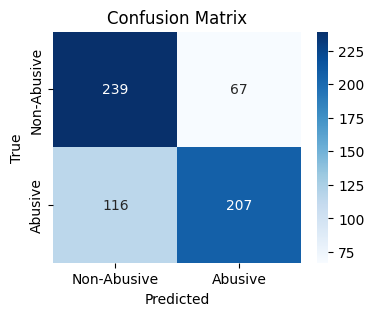

In [20]:
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Evaluate on the test set
model.eval()  # Set the model to evaluation mode

all_preds = []
all_targets = []

test_bar = tqdm(test_loader, desc="Evaluating on Test Set")

with torch.no_grad():
    for batch in test_bar:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)

        outputs = model(ids, mask)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        if 'targets' in batch:  # Only collect true labels if they exist
            all_targets.extend(batch['targets'].cpu().numpy())  # Collect true labels

# Generate the classification report if labels exist
if len(all_targets) > 0:
    # Print classification report
    report = classification_report(all_targets, all_preds, target_names=['Non-Abusive', 'Abusive'])
    print("Classification Report on Test Set:")
    print(report)

    # Compute the confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Abusive', 'Abusive'], yticklabels=['Non-Abusive', 'Abusive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

else:
    print("Test set does not contain labels, only predictions are available.")


In [30]:
# Set the model to evaluation mode
model.eval()

all_preds = []
all_targets = []
sample_texts = []  
test_df = test_with_label[['cleanText', 'enc_label']]
test_bar = tqdm(test_loader, desc="Evaluating on Test Set")

with torch.no_grad():
    for batch_idx, batch in enumerate(test_bar):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(ids, mask)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        all_targets.extend(targets.cpu().numpy())  # Collect true labels

        # Collect the 'cleanText' for the current batch from the test dataframe
        start_idx = batch_idx * BATCH_SIZE
        end_idx = start_idx + len(batch['ids'])
        sample_texts.extend(test_df['cleanText'].iloc[start_idx:end_idx].tolist())

# Display some sample predictions
num_samples = 8  # Number of examples to display
sample_indices = np.random.choice(len(all_targets), num_samples, replace=False)

# Prepare the sample data for display
sample_data = {
    "Text": [sample_texts[i] for i in sample_indices],
    "Actual and Predicted Label": [
        f"{all_targets[i]} -> {all_preds[i]}" for i in sample_indices  # Display just 0 or 1
    ]
}
sample_df = pd.DataFrame(sample_data)

# Display the sample predictions
print("\nSample Predictions:")
print(sample_df)

Evaluating on Test Set: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Sample Predictions:
                                                Text  \
0  നിങ്ങളെ ഒരുപാട് ഇഷ്ട്ടം ആയിരുന്നു ഇപ്പോ ഫുൾ അഭ...   
1  ഇതൊക്കെ ആരാ എഴുതി തരുന്നത് കണ്ടാ പറയില്ലട്ടാ ബ...   
2  ഇനി വീണസ്ഥലത്ത് കിടന്ന് ഉരുളണ്ട ഞങ്ങൾ മണ്ടന്മാ...   
3  കൈ വിട്ട ആയുധവും വാ വിട്ട വാക്കും തിരിച്ചെടുക്...   
4           ഈ പ്രശ്നത്തിൽ ഇടപെടാൻ ഈ സൂരജ് മൈരൻ ആരാണ്   
5  ഒരുപാട് ഇഷ്ടപ്പെട്ടിരിന്നു നിങ്ങളുടെ കോംബോ പക്...   
6  നീ 50ലക്ഷത്തിനു അർഹയല്ല നിന്നെക്കാൾ അർഹതയുള്ളവ...   
7  സീരിയസ് ആയിട്ട് പറഞ്ഞതാണെങ്കിൽ വൻ കോമഡി ആയിട്ട...   

  Actual and Predicted Label  
0                     0 -> 1  
1                     1 -> 1  
2                     0 -> 1  
3                     0 -> 0  
4                     0 -> 0  
5                     0 -> 0  
6                     1 -> 0  
7                     1 -> 0  


**Another iteration**

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import AdamW
import torch.nn as nn
from tqdm import tqdm

# Set a random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define tokenizer for the selected model
model_name = 'l3cube-pune/malayalam-bert'  # Change model as needed
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Constants
MAX_LEN = 256
BATCH_SIZE = 16
source_to_idx = {'Abusive': 1, 'Non-Abusive': 0}

# Prepare datasets
train_df['enc_label'] = train_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
dev_df['enc_label'] = dev_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
test_with_label['enc_label'] = test_with_label['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')  # Fix here

X_train_text = train_df['cleanText'].tolist()
y_train_labels = train_df['enc_label'].tolist()

X_dev_text = dev_df['cleanText'].tolist()
y_dev_labels = dev_df['enc_label'].tolist()
X_test_text = test_with_label['cleanText'].tolist()
y_test_labels = test_with_label['enc_label'].tolist()  # Ensure labels are here

# Create dataset objects
class NewsDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()
        
        if self.is_labeled and self.labels is not None:  # Check if labels are provided
            label = self.labels[item]
            return {
                'ids': input_ids,
                'mask': attention_mask,
                'targets': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'ids': input_ids,
                'mask': attention_mask
            }

train_set = NewsDataset(X_train_text, y_train_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
dev_set = NewsDataset(X_dev_text, y_dev_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
test_set = NewsDataset(X_test_text, y_test_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)  # Pass labels here

# Create data loaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

<ipython-input-18-707c84496ac0>:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['enc_label'] = train_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
<ipython-input-18-707c84496ac0>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dev_df['enc_label'] = dev_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
<ipython-input-18-707c84496ac0>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicit

In [19]:
from transformers import AutoModel
# BERT Classifier Model
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(0.4)
        self.out = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        output = self.drop(pooled_output)
        return self.out(output)

# Initialize model
model = BERTClassifier(model_name=model_name, num_labels=len(source_to_idx))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model.to(device)


config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/951M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at l3cube-pune/malayalam-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [20]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),  # Convert classes to a NumPy array
    y=train_df['enc_label']
)

# Convert class weights to a tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [21]:
# Define optimizer and loss function
optimizer = AdamW(params=model.parameters(), lr=3e-6, weight_decay=1e-4)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
# Training loop
EPOCHS = 12
for epoch in range(EPOCHS):
    model.train()
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training")

    total_train_loss = 0
    total_train_correct = 0
    total_train_samples = 0

    for batch in train_bar:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(ids, mask)

        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == targets).sum().item()
        total_train_samples += targets.size(0)

        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_train_correct / total_train_samples

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_samples = 0
    dev_bar = tqdm(dev_loader, desc=f"Epoch {epoch+1} - Validation")

    with torch.no_grad():
        for batch in dev_bar:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == targets).sum().item()
            total_val_samples += targets.size(0)

            dev_bar.set_postfix(loss=loss.item())

    avg_val_loss = total_val_loss / len(dev_loader)
    val_accuracy = total_val_correct / total_val_samples

    print(f"Epoch {epoch + 1} | "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f} | "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on the test set
model.eval()  # Set the model to evaluation mode

all_preds = []
all_targets = []

test_bar = tqdm(test_loader, desc="Evaluating on Test Set")

with torch.no_grad():
    for batch in test_bar:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)

        outputs = model(ids, mask)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        if 'targets' in batch:  # Only collect true labels if they exist
            all_targets.extend(batch['targets'].cpu().numpy())  # Collect true labels

# Generate the classification report if labels exist
if len(all_targets) > 0:
    report = classification_report(all_targets, all_preds, target_names=['Non-Abusive', 'Abusive'])
    print("Classification Report on Test Set:")
    print(report)
else:
    print("Test set does not contain labels, only predictions are available.")

Epoch 1 - Validation: 100%|██████████| 40/40 [00:09<00:00,  4.43it/s, loss=0.698]


Epoch 1 | Training Loss: 0.6933, Training Accuracy: 0.5220 | Validation Loss: 0.6944, Validation Accuracy: 0.4817


Epoch 2 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.57it/s, loss=0.668]


Epoch 2 | Training Loss: 0.6896, Training Accuracy: 0.5404 | Validation Loss: 0.6758, Validation Accuracy: 0.6979


Epoch 3 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.58it/s, loss=0.573]


Epoch 3 | Training Loss: 0.6564, Training Accuracy: 0.7027 | Validation Loss: 0.6225, Validation Accuracy: 0.7313


Epoch 4 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.56it/s, loss=0.63] 


Epoch 4 | Training Loss: 0.6020, Training Accuracy: 0.7634 | Validation Loss: 0.5885, Validation Accuracy: 0.7488


Epoch 5 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.56it/s, loss=0.644]


Epoch 5 | Training Loss: 0.5490, Training Accuracy: 0.8026 | Validation Loss: 0.5655, Validation Accuracy: 0.7552


Epoch 6 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.56it/s, loss=0.573]


Epoch 6 | Training Loss: 0.4951, Training Accuracy: 0.8282 | Validation Loss: 0.5445, Validation Accuracy: 0.7599


Epoch 7 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.55it/s, loss=0.709]


Epoch 7 | Training Loss: 0.4512, Training Accuracy: 0.8479 | Validation Loss: 0.5397, Validation Accuracy: 0.7615


Epoch 8 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.56it/s, loss=0.795]


Epoch 8 | Training Loss: 0.4018, Training Accuracy: 0.8725 | Validation Loss: 0.5383, Validation Accuracy: 0.7647


Epoch 9 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.55it/s, loss=0.872]


Epoch 9 | Training Loss: 0.3611, Training Accuracy: 0.8899 | Validation Loss: 0.5577, Validation Accuracy: 0.7568


Epoch 10 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.57it/s, loss=0.921]


Epoch 10 | Training Loss: 0.3364, Training Accuracy: 0.8974 | Validation Loss: 0.5840, Validation Accuracy: 0.7536


Epoch 11 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.55it/s, loss=0.901]


Epoch 11 | Training Loss: 0.3179, Training Accuracy: 0.9011 | Validation Loss: 0.5706, Validation Accuracy: 0.7695


Epoch 12 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.57it/s, loss=0.952]


Epoch 12 | Training Loss: 0.2869, Training Accuracy: 0.9161 | Validation Loss: 0.5881, Validation Accuracy: 0.7615


Evaluating on Test Set: 100%|██████████| 40/40 [00:08<00:00,  4.57it/s]

Classification Report on Test Set:
              precision    recall  f1-score   support

 Non-Abusive       0.63      0.84      0.72       306
     Abusive       0.78      0.54      0.64       323

    accuracy                           0.69       629
   macro avg       0.71      0.69      0.68       629
weighted avg       0.71      0.69      0.68       629



Evaluating on Test Set: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]


Classification Report on Test Set:
              precision    recall  f1-score   support

 Non-Abusive       0.63      0.84      0.72       306
     Abusive       0.78      0.54      0.64       323

    accuracy                           0.69       629
   macro avg       0.71      0.69      0.68       629
weighted avg       0.71      0.69      0.68       629



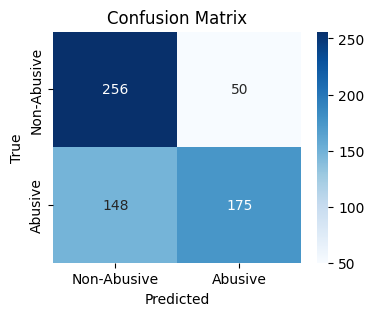

In [22]:
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Evaluate on the test set
model.eval()  # Set the model to evaluation mode

all_preds = []
all_targets = []

test_bar = tqdm(test_loader, desc="Evaluating on Test Set")

with torch.no_grad():
    for batch in test_bar:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)

        outputs = model(ids, mask)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        if 'targets' in batch:  # Only collect true labels if they exist
            all_targets.extend(batch['targets'].cpu().numpy())  # Collect true labels

# Generate the classification report if labels exist
if len(all_targets) > 0:
    # Print classification report
    report = classification_report(all_targets, all_preds, target_names=['Non-Abusive', 'Abusive'])
    print("Classification Report on Test Set:")
    print(report)

    # Compute the confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Abusive', 'Abusive'], yticklabels=['Non-Abusive', 'Abusive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

else:
    print("Test set does not contain labels, only predictions are available.")

**xlm-roberta-base**

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import AdamW
import torch.nn as nn
from tqdm import tqdm

# Set a random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define tokenizer for the selected model
model_name = 'FacebookAI/xlm-roberta-base'  # Change model as needed
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Constants
MAX_LEN = 256
BATCH_SIZE = 32
source_to_idx = {'Abusive': 1, 'Non-Abusive': 0}

# Prepare datasets
train_df['enc_label'] = train_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
dev_df['enc_label'] = dev_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
test_with_label['enc_label'] = test_with_label['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')  # Fix here

X_train_text = train_df['cleanText'].tolist()
y_train_labels = train_df['enc_label'].tolist()

X_dev_text = dev_df['cleanText'].tolist()
y_dev_labels = dev_df['enc_label'].tolist()
X_test_text = test_with_label['cleanText'].tolist()
y_test_labels = test_with_label['enc_label'].tolist()  # Ensure labels are here

# Create dataset objects
class NewsDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()
        
        if self.is_labeled and self.labels is not None:  # Check if labels are provided
            label = self.labels[item]
            return {
                'ids': input_ids,
                'mask': attention_mask,
                'targets': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'ids': input_ids,
                'mask': attention_mask
            }

train_set = NewsDataset(X_train_text, y_train_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
dev_set = NewsDataset(X_dev_text, y_dev_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
test_set = NewsDataset(X_test_text, y_test_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)  # Pass labels here

# Create data loaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

<ipython-input-14-7e7b8befda10>:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['enc_label'] = train_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
<ipython-input-14-7e7b8befda10>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dev_df['enc_label'] = dev_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
<ipython-input-14-7e7b8befda10>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicit

In [15]:
from transformers import AutoModel
# BERT Classifier Model
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        output = self.drop(pooled_output)
        return self.out(output)

# Initialize model
model = BERTClassifier(model_name=model_name, num_labels=len(source_to_idx))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model.to(device)


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

BERTClassifier(
  (bert): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

In [16]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),  # Convert classes to a NumPy array
    y=train_df['enc_label']
)

# Convert class weights to a tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [17]:
# Define optimizer and loss function
optimizer = AdamW(params=model.parameters(), lr=2e-6, weight_decay=1e-4)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
# Training loop
EPOCHS = 15
for epoch in range(EPOCHS):
    model.train()
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training")

    total_train_loss = 0
    total_train_correct = 0
    total_train_samples = 0

    for batch in train_bar:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(ids, mask)

        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == targets).sum().item()
        total_train_samples += targets.size(0)

        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_train_correct / total_train_samples

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_samples = 0
    dev_bar = tqdm(dev_loader, desc=f"Epoch {epoch+1} - Validation")

    with torch.no_grad():
        for batch in dev_bar:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == targets).sum().item()
            total_val_samples += targets.size(0)

            dev_bar.set_postfix(loss=loss.item())

    avg_val_loss = total_val_loss / len(dev_loader)
    val_accuracy = total_val_correct / total_val_samples

    print(f"Epoch {epoch + 1} | "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f} | "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on the test set
model.eval()  # Set the model to evaluation mode

all_preds = []
all_targets = []

test_bar = tqdm(test_loader, desc="Evaluating on Test Set")

with torch.no_grad():
    for batch in test_bar:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)

        outputs = model(ids, mask)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        if 'targets' in batch:  # Only collect true labels if they exist
            all_targets.extend(batch['targets'].cpu().numpy())  # Collect true labels

# Generate the classification report if labels exist
if len(all_targets) > 0:
    report = classification_report(all_targets, all_preds, target_names=['Non-Abusive', 'Abusive'])
    print("Classification Report on Test Set:")
    print(report)
else:
    print("Test set does not contain labels, only predictions are available.")

Epoch 1 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.36it/s, loss=0.687]


Epoch 1 | Training Loss: 0.7170, Training Accuracy: 0.4944 | Validation Loss: 0.6901, Validation Accuracy: 0.5183


Epoch 2 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.42it/s, loss=0.678]


Epoch 2 | Training Loss: 0.7054, Training Accuracy: 0.4937 | Validation Loss: 0.6839, Validation Accuracy: 0.5342


Epoch 3 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.42it/s, loss=0.653]


Epoch 3 | Training Loss: 0.6984, Training Accuracy: 0.5309 | Validation Loss: 0.6707, Validation Accuracy: 0.5819


Epoch 4 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s, loss=0.631]


Epoch 4 | Training Loss: 0.6844, Training Accuracy: 0.5673 | Validation Loss: 0.6422, Validation Accuracy: 0.6582


Epoch 5 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s, loss=0.624]


Epoch 5 | Training Loss: 0.6779, Training Accuracy: 0.5714 | Validation Loss: 0.6294, Validation Accuracy: 0.6789


Epoch 6 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s, loss=0.646]


Epoch 6 | Training Loss: 0.6677, Training Accuracy: 0.5885 | Validation Loss: 0.6319, Validation Accuracy: 0.6598


Epoch 7 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s, loss=0.641]


Epoch 7 | Training Loss: 0.6704, Training Accuracy: 0.5806 | Validation Loss: 0.6420, Validation Accuracy: 0.6391


Epoch 8 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.42it/s, loss=0.668]


Epoch 8 | Training Loss: 0.6788, Training Accuracy: 0.5827 | Validation Loss: 0.6493, Validation Accuracy: 0.6169


Epoch 9 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s, loss=0.618]


Epoch 9 | Training Loss: 0.6705, Training Accuracy: 0.5932 | Validation Loss: 0.6239, Validation Accuracy: 0.6852


Epoch 10 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s, loss=0.598]


Epoch 10 | Training Loss: 0.6457, Training Accuracy: 0.6365 | Validation Loss: 0.6018, Validation Accuracy: 0.7027


Epoch 11 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.42it/s, loss=0.596]


Epoch 11 | Training Loss: 0.6350, Training Accuracy: 0.6526 | Validation Loss: 0.6023, Validation Accuracy: 0.6932


Epoch 12 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.40it/s, loss=0.6]  


Epoch 12 | Training Loss: 0.6320, Training Accuracy: 0.6502 | Validation Loss: 0.5878, Validation Accuracy: 0.7043


Epoch 13 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.42it/s, loss=0.581]


Epoch 13 | Training Loss: 0.6175, Training Accuracy: 0.6580 | Validation Loss: 0.5805, Validation Accuracy: 0.7122


Epoch 14 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.42it/s, loss=0.628]


Epoch 14 | Training Loss: 0.6038, Training Accuracy: 0.6723 | Validation Loss: 0.5887, Validation Accuracy: 0.7138


Epoch 15 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.40it/s, loss=0.606]


Epoch 15 | Training Loss: 0.5992, Training Accuracy: 0.6775 | Validation Loss: 0.5870, Validation Accuracy: 0.7043


Evaluating on Test Set: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s]

Classification Report on Test Set:
              precision    recall  f1-score   support

 Non-Abusive       0.60      0.81      0.69       306
     Abusive       0.73      0.49      0.59       323

    accuracy                           0.65       629
   macro avg       0.67      0.65      0.64       629
weighted avg       0.67      0.65      0.64       629



**bert-base-multilingual-cased**


In [32]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import AdamW
import torch.nn as nn
from tqdm import tqdm

# Set a random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define tokenizer for the selected model
model_name = 'google-bert/bert-base-multilingual-cased'  # Change model as needed
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Constants
MAX_LEN = 256
BATCH_SIZE = 16
source_to_idx = {'Abusive': 1, 'Non-Abusive': 0}

# Prepare datasets
train_df['enc_label'] = train_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
dev_df['enc_label'] = dev_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
test_with_label['enc_label'] = test_with_label['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')  # Fix here

X_train_text = train_df['cleanText'].tolist()
y_train_labels = train_df['enc_label'].tolist()

X_dev_text = dev_df['cleanText'].tolist()
y_dev_labels = dev_df['enc_label'].tolist()
X_test_text = test_with_label['cleanText'].tolist()
y_test_labels = test_with_label['enc_label'].tolist()  # Ensure labels are here

# Create dataset objects
class NewsDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()
        
        if self.is_labeled and self.labels is not None:  # Check if labels are provided
            label = self.labels[item]
            return {
                'ids': input_ids,
                'mask': attention_mask,
                'targets': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'ids': input_ids,
                'mask': attention_mask
            }

train_set = NewsDataset(X_train_text, y_train_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
dev_set = NewsDataset(X_dev_text, y_dev_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
test_set = NewsDataset(X_test_text, y_test_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)  # Pass labels here

# Create data loaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


<ipython-input-32-7d4b9b69277f>:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['enc_label'] = train_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
<ipython-input-32-7d4b9b69277f>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dev_df['enc_label'] = dev_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
<ipython-input-32-7d4b9b69277f>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicit

In [33]:
from transformers import AutoModel
# BERT Classifier Model
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(0.4)
        self.out = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        output = self.drop(pooled_output)
        return self.out(output)

# Initialize model
model = BERTClassifier(model_name=model_name, num_labels=len(source_to_idx))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model.to(device)


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),  # Convert classes to a NumPy array
    y=train_df['enc_label']
)

# Convert class weights to a tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [34]:
# Define optimizer and loss function
optimizer = AdamW(params=model.parameters(), lr=3e-6, weight_decay=1e-5)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
# Training loop
EPOCHS = 15
for epoch in range(EPOCHS):
    model.train()
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training")

    total_train_loss = 0
    total_train_correct = 0
    total_train_samples = 0

    for batch in train_bar:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(ids, mask)

        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == targets).sum().item()
        total_train_samples += targets.size(0)

        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_train_correct / total_train_samples

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_samples = 0
    dev_bar = tqdm(dev_loader, desc=f"Epoch {epoch+1} - Validation")

    with torch.no_grad():
        for batch in dev_bar:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == targets).sum().item()
            total_val_samples += targets.size(0)

            dev_bar.set_postfix(loss=loss.item())

    avg_val_loss = total_val_loss / len(dev_loader)
    val_accuracy = total_val_correct / total_val_samples

    print(f"Epoch {epoch + 1} | "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f} | "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on the test set
model.eval()  # Set the model to evaluation mode

all_preds = []
all_targets = []

test_bar = tqdm(test_loader, desc="Evaluating on Test Set")

with torch.no_grad():
    for batch in test_bar:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)

        outputs = model(ids, mask)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        if 'targets' in batch:  # Only collect true labels if they exist
            all_targets.extend(batch['targets'].cpu().numpy())  # Collect true labels

# Generate the classification report if labels exist
if len(all_targets) > 0:
    report = classification_report(all_targets, all_preds, target_names=['Non-Abusive', 'Abusive'])
    print("Classification Report on Test Set:")
    print(report)
else:
    print("Test set does not contain labels, only predictions are available.")

Epoch 1 - Validation: 100%|██████████| 40/40 [00:09<00:00,  4.43it/s, loss=0.601]


Epoch 1 | Training Loss: 0.6916, Training Accuracy: 0.5346 | Validation Loss: 0.6488, Validation Accuracy: 0.6264


Epoch 2 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.45it/s, loss=0.599]


Epoch 2 | Training Loss: 0.6610, Training Accuracy: 0.6035 | Validation Loss: 0.6273, Validation Accuracy: 0.6757


Epoch 3 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.45it/s, loss=0.573]


Epoch 3 | Training Loss: 0.6146, Training Accuracy: 0.6628 | Validation Loss: 0.5986, Validation Accuracy: 0.6773


Epoch 4 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.46it/s, loss=0.43] 


Epoch 4 | Training Loss: 0.5604, Training Accuracy: 0.7119 | Validation Loss: 0.6000, Validation Accuracy: 0.6773


Epoch 5 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.47it/s, loss=0.375]


Epoch 5 | Training Loss: 0.5113, Training Accuracy: 0.7535 | Validation Loss: 0.6340, Validation Accuracy: 0.6900


Epoch 6 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.48it/s, loss=0.311]


Epoch 6 | Training Loss: 0.4595, Training Accuracy: 0.7924 | Validation Loss: 0.6402, Validation Accuracy: 0.6979


Epoch 7 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.46it/s, loss=0.347]


Epoch 7 | Training Loss: 0.3906, Training Accuracy: 0.8323 | Validation Loss: 0.6858, Validation Accuracy: 0.6868


Epoch 8 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.47it/s, loss=0.485]


Epoch 8 | Training Loss: 0.3410, Training Accuracy: 0.8609 | Validation Loss: 0.7680, Validation Accuracy: 0.6900


Epoch 9 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.46it/s, loss=0.467]


Epoch 9 | Training Loss: 0.2980, Training Accuracy: 0.8776 | Validation Loss: 0.7438, Validation Accuracy: 0.6868


Epoch 10 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.48it/s, loss=0.267]


Epoch 10 | Training Loss: 0.2494, Training Accuracy: 0.9028 | Validation Loss: 0.8317, Validation Accuracy: 0.6900


Epoch 11 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.47it/s, loss=0.666]


Epoch 11 | Training Loss: 0.2077, Training Accuracy: 0.9236 | Validation Loss: 0.8678, Validation Accuracy: 0.6900


Epoch 12 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.46it/s, loss=0.59] 


Epoch 12 | Training Loss: 0.1764, Training Accuracy: 0.9403 | Validation Loss: 0.9066, Validation Accuracy: 0.6900


Epoch 13 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.45it/s, loss=0.43] 


Epoch 13 | Training Loss: 0.1597, Training Accuracy: 0.9407 | Validation Loss: 0.9771, Validation Accuracy: 0.6900


Epoch 14 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.45it/s, loss=0.303]


Epoch 14 | Training Loss: 0.1470, Training Accuracy: 0.9506 | Validation Loss: 1.0042, Validation Accuracy: 0.6932


Epoch 15 - Validation: 100%|██████████| 40/40 [00:08<00:00,  4.46it/s, loss=0.229]


Epoch 15 | Training Loss: 0.1133, Training Accuracy: 0.9659 | Validation Loss: 1.0186, Validation Accuracy: 0.6836


Evaluating on Test Set: 100%|██████████| 40/40 [00:09<00:00,  4.28it/s]

Classification Report on Test Set:
              precision    recall  f1-score   support

 Non-Abusive       0.63      0.76      0.69       306
     Abusive       0.72      0.58      0.64       323

    accuracy                           0.67       629
   macro avg       0.68      0.67      0.67       629
weighted avg       0.68      0.67      0.67       629



**Another iteration**

In [23]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import AdamW
import torch.nn as nn
from tqdm import tqdm

# Set a random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define tokenizer for the selected model
model_name = 'google-bert/bert-base-multilingual-cased'  # Change model as needed
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Constants
MAX_LEN = 256
BATCH_SIZE = 32
source_to_idx = {'Abusive': 1, 'Non-Abusive': 0}

# Prepare datasets
train_df['enc_label'] = train_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
dev_df['enc_label'] = dev_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
test_with_label['enc_label'] = test_with_label['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')  # Fix here

X_train_text = train_df['cleanText'].tolist()
y_train_labels = train_df['enc_label'].tolist()

X_dev_text = dev_df['cleanText'].tolist()
y_dev_labels = dev_df['enc_label'].tolist()
X_test_text = test_with_label['cleanText'].tolist()
y_test_labels = test_with_label['enc_label'].tolist()  # Ensure labels are here

# Create dataset objects
class NewsDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()
        
        if self.is_labeled and self.labels is not None:  # Check if labels are provided
            label = self.labels[item]
            return {
                'ids': input_ids,
                'mask': attention_mask,
                'targets': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'ids': input_ids,
                'mask': attention_mask
            }

train_set = NewsDataset(X_train_text, y_train_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
dev_set = NewsDataset(X_dev_text, y_dev_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
test_set = NewsDataset(X_test_text, y_test_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)  # Pass labels here

# Create data loaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

<ipython-input-23-5959eca345a6>:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['enc_label'] = train_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
<ipython-input-23-5959eca345a6>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dev_df['enc_label'] = dev_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
<ipython-input-23-5959eca345a6>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicit

In [24]:
from transformers import AutoModel
# BERT Classifier Model
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        output = self.drop(pooled_output)
        return self.out(output)

# Initialize model
model = BERTClassifier(model_name=model_name, num_labels=len(source_to_idx))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model.to(device)


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [25]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),  # Convert classes to a NumPy array
    y=train_df['enc_label']
)

# Convert class weights to a tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [26]:
# Define optimizer and loss function
optimizer = AdamW(params=model.parameters(), lr=2e-6, weight_decay=1e-6)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
# Training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training")

    total_train_loss = 0
    total_train_correct = 0
    total_train_samples = 0

    for batch in train_bar:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(ids, mask)

        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == targets).sum().item()
        total_train_samples += targets.size(0)

        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_train_correct / total_train_samples

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_samples = 0
    dev_bar = tqdm(dev_loader, desc=f"Epoch {epoch+1} - Validation")

    with torch.no_grad():
        for batch in dev_bar:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == targets).sum().item()
            total_val_samples += targets.size(0)

            dev_bar.set_postfix(loss=loss.item())

    avg_val_loss = total_val_loss / len(dev_loader)
    val_accuracy = total_val_correct / total_val_samples

    print(f"Epoch {epoch + 1} | "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f} | "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on the test set
model.eval()  # Set the model to evaluation mode

all_preds = []
all_targets = []

test_bar = tqdm(test_loader, desc="Evaluating on Test Set")

with torch.no_grad():
    for batch in test_bar:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)

        outputs = model(ids, mask)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        if 'targets' in batch:  # Only collect true labels if they exist
            all_targets.extend(batch['targets'].cpu().numpy())  # Collect true labels

# Generate the classification report if labels exist
if len(all_targets) > 0:
    report = classification_report(all_targets, all_preds, target_names=['Non-Abusive', 'Abusive'])
    print("Classification Report on Test Set:")
    print(report)
else:
    print("Test set does not contain labels, only predictions are available.")

Epoch 1 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.14it/s, loss=0.671]


Epoch 1 | Training Loss: 0.6957, Training Accuracy: 0.5012 | Validation Loss: 0.6737, Validation Accuracy: 0.6312


Epoch 2 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s, loss=0.632]


Epoch 2 | Training Loss: 0.6779, Training Accuracy: 0.5677 | Validation Loss: 0.6294, Validation Accuracy: 0.6630


Epoch 3 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s, loss=0.611]


Epoch 3 | Training Loss: 0.6557, Training Accuracy: 0.6100 | Validation Loss: 0.6105, Validation Accuracy: 0.6502


Epoch 4 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s, loss=0.6]  


Epoch 4 | Training Loss: 0.6240, Training Accuracy: 0.6546 | Validation Loss: 0.5910, Validation Accuracy: 0.6677


Epoch 5 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s, loss=0.601]


Epoch 5 | Training Loss: 0.5837, Training Accuracy: 0.6918 | Validation Loss: 0.5838, Validation Accuracy: 0.6804


Epoch 6 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s, loss=0.606]


Epoch 6 | Training Loss: 0.5434, Training Accuracy: 0.7361 | Validation Loss: 0.5874, Validation Accuracy: 0.6916


Epoch 7 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s, loss=0.647]


Epoch 7 | Training Loss: 0.5190, Training Accuracy: 0.7422 | Validation Loss: 0.5952, Validation Accuracy: 0.6963


Epoch 8 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s, loss=0.608]


Epoch 8 | Training Loss: 0.4797, Training Accuracy: 0.7780 | Validation Loss: 0.6234, Validation Accuracy: 0.6900


Epoch 9 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.15it/s, loss=0.658]


Epoch 9 | Training Loss: 0.4538, Training Accuracy: 0.8012 | Validation Loss: 0.6146, Validation Accuracy: 0.6995


Epoch 10 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s, loss=0.714]


Epoch 10 | Training Loss: 0.4147, Training Accuracy: 0.8179 | Validation Loss: 0.6709, Validation Accuracy: 0.6963


Evaluating on Test Set: 100%|██████████| 20/20 [00:09<00:00,  2.14it/s]

Classification Report on Test Set:
              precision    recall  f1-score   support

 Non-Abusive       0.60      0.84      0.70       306
     Abusive       0.75      0.47      0.58       323

    accuracy                           0.65       629
   macro avg       0.68      0.66      0.64       629
weighted avg       0.68      0.65      0.64       629



**Indic-bert**

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import AdamW
import torch.nn as nn
from tqdm import tqdm

# Set a random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Define tokenizer for the selected model
model_name = 'ai4bharat/indic-bert'  # Change model as needed
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Constants
MAX_LEN = 256
BATCH_SIZE = 32
source_to_idx = {'Abusive': 1, 'Non-Abusive': 0}

# Prepare datasets
train_df['enc_label'] = train_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
dev_df['enc_label'] = dev_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
test_with_label['enc_label'] = test_with_label['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')  # Fix here

X_train_text = train_df['cleanText'].tolist()
y_train_labels = train_df['enc_label'].tolist()

X_dev_text = dev_df['cleanText'].tolist()
y_dev_labels = dev_df['enc_label'].tolist()
X_test_text = test_with_label['cleanText'].tolist()
y_test_labels = test_with_label['enc_label'].tolist()  # Ensure labels are here

# Create dataset objects
class NewsDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()
        
        if self.is_labeled and self.labels is not None:  # Check if labels are provided
            label = self.labels[item]
            return {
                'ids': input_ids,
                'mask': attention_mask,
                'targets': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'ids': input_ids,
                'mask': attention_mask
            }

train_set = NewsDataset(X_train_text, y_train_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
dev_set = NewsDataset(X_dev_text, y_dev_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)
test_set = NewsDataset(X_test_text, y_test_labels, tokenizer=tokenizer, max_len=MAX_LEN, is_labeled=True)  # Pass labels here

# Create data loaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

<ipython-input-15-faa48951d4fb>:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['enc_label'] = train_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
<ipython-input-15-faa48951d4fb>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dev_df['enc_label'] = dev_df['Class'].replace({'Abusive': 1, 'Non-Abusive': 0}).astype('int64')
<ipython-input-15-faa48951d4fb>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicit

In [16]:
from transformers import AutoModel
# BERT Classifier Model
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        output = self.drop(pooled_output)
        return self.out(output)

# Initialize model
model = BERTClassifier(model_name=model_name, num_labels=len(source_to_idx))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model.to(device)


pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

BERTClassifier(
  (bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(200000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
  

In [17]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),  # Convert classes to a NumPy array
    y=train_df['enc_label']
)

# Convert class weights to a tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [18]:
# Define optimizer and loss function
optimizer = AdamW(params=model.parameters(), lr=2e-6, weight_decay=1e-6)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
# Training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training")

    total_train_loss = 0
    total_train_correct = 0
    total_train_samples = 0

    for batch in train_bar:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(ids, mask)

        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == targets).sum().item()
        total_train_samples += targets.size(0)

        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_train_correct / total_train_samples

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_samples = 0
    dev_bar = tqdm(dev_loader, desc=f"Epoch {epoch+1} - Validation")

    with torch.no_grad():
        for batch in dev_bar:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == targets).sum().item()
            total_val_samples += targets.size(0)

            dev_bar.set_postfix(loss=loss.item())

    avg_val_loss = total_val_loss / len(dev_loader)
    val_accuracy = total_val_correct / total_val_samples

    print(f"Epoch {epoch + 1} | "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f} | "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on the test set
model.eval()  # Set the model to evaluation mode

all_preds = []
all_targets = []

test_bar = tqdm(test_loader, desc="Evaluating on Test Set")

with torch.no_grad():
    for batch in test_bar:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)

        outputs = model(ids, mask)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        if 'targets' in batch:  # Only collect true labels if they exist
            all_targets.extend(batch['targets'].cpu().numpy())  # Collect true labels

# Generate the classification report if labels exist
if len(all_targets) > 0:
    report = classification_report(all_targets, all_preds, target_names=['Non-Abusive', 'Abusive'])
    print("Classification Report on Test Set:")
    print(report)
else:
    print("Test set does not contain labels, only predictions are available.")

Epoch 1 - Validation: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s, loss=0.693]


Epoch 1 | Training Loss: 0.6932, Training Accuracy: 0.5073 | Validation Loss: 0.6935, Validation Accuracy: 0.4817


Epoch 2 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s, loss=0.692]


Epoch 2 | Training Loss: 0.6930, Training Accuracy: 0.5080 | Validation Loss: 0.6930, Validation Accuracy: 0.4976


Epoch 3 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s, loss=0.688]


Epoch 3 | Training Loss: 0.6927, Training Accuracy: 0.5063 | Validation Loss: 0.6910, Validation Accuracy: 0.5978


Epoch 4 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s, loss=0.68] 


Epoch 4 | Training Loss: 0.6907, Training Accuracy: 0.5377 | Validation Loss: 0.6880, Validation Accuracy: 0.6025


Epoch 5 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.21it/s, loss=0.653]


Epoch 5 | Training Loss: 0.6802, Training Accuracy: 0.6086 | Validation Loss: 0.6766, Validation Accuracy: 0.6057


Epoch 6 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.20it/s, loss=0.616]


Epoch 6 | Training Loss: 0.6616, Training Accuracy: 0.6505 | Validation Loss: 0.6663, Validation Accuracy: 0.6121


Epoch 7 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s, loss=0.622]


Epoch 7 | Training Loss: 0.6366, Training Accuracy: 0.6846 | Validation Loss: 0.6621, Validation Accuracy: 0.6105


Epoch 8 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.21it/s, loss=0.59] 


Epoch 8 | Training Loss: 0.6137, Training Accuracy: 0.7153 | Validation Loss: 0.6691, Validation Accuracy: 0.6169


Epoch 9 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s, loss=0.617]


Epoch 9 | Training Loss: 0.5847, Training Accuracy: 0.7463 | Validation Loss: 0.6725, Validation Accuracy: 0.6264


Epoch 10 - Validation: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s, loss=0.702]


Epoch 10 | Training Loss: 0.5603, Training Accuracy: 0.7678 | Validation Loss: 0.7226, Validation Accuracy: 0.6041


Evaluating on Test Set: 100%|██████████| 20/20 [00:08<00:00,  2.22it/s]

Classification Report on Test Set:
              precision    recall  f1-score   support

 Non-Abusive       0.55      0.70      0.62       306
     Abusive       0.62      0.46      0.53       323

    accuracy                           0.58       629
   macro avg       0.59      0.58      0.57       629
weighted avg       0.59      0.58      0.57       629

